In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [214]:
# Cargar el archivo
df = pd.read_excel("American Ninja Warrior Obstacle History.xlsx")
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Ordenar por obstáculo y temporada
df = df.sort_values(by=["Obstacle_Name", "Season"])

# Crear columna que contiene la próxima temporada del obstáculo
df["siguiente_temp"] = df.groupby("Obstacle_Name")["Season"].shift(-1)

# Etiqueta binaria: ¿aparece en la siguiente temporada?
df["vuelve_en_siguiente"] = (df["siguiente_temp"] == df["Season"] + 1).astype(int)

# Filtrar filas válidas para entrenamiento (hasta penúltima aparición)
df_entrenamiento = df.dropna(subset=["siguiente_temp"]).copy()


In [215]:
# Calcular estadísticas por obstáculo hasta esa temporada
df_entrenamiento["apariciones_previas"] = df_entrenamiento.groupby("Obstacle_Name")["Season"].transform("count")
df_entrenamiento["orden_promedio"] = df_entrenamiento.groupby("Obstacle_Name")["Obstacle_Order"].transform("mean")
df_entrenamiento["etapas_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Round/Stage"].transform("nunique")
df_entrenamiento["ubicaciones_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Location"].transform("nunique")


In [216]:
# Seleccionar X e y
X = df_entrenamiento[[
    "Season", "Obstacle_Order", "apariciones_previas",
    "orden_promedio", "etapas_diferentes", "ubicaciones_diferentes"
]]
y = df_entrenamiento["vuelve_en_siguiente"]

# División entrenamiento/prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalización
escalador = StandardScaler()
X_entrenamiento_escalado = escalador.fit_transform(X_entrenamiento)
X_prueba_escalado = escalador.transform(X_prueba)


In [217]:
modelo = LogisticRegression()
modelo.fit(X_entrenamiento_escalado, y_entrenamiento)


LogisticRegression()

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

   No Vuelve       0.71      0.81      0.76        85
      Vuelve       0.56      0.42      0.48        48

    accuracy                           0.67       133
   macro avg       0.63      0.61      0.62       133
weighted avg       0.66      0.67      0.66       133



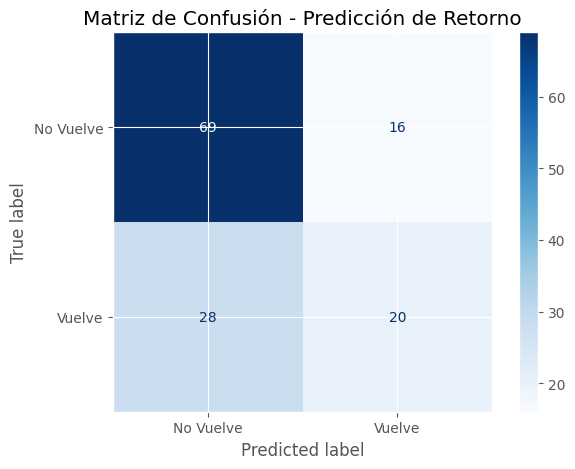

In [222]:
y_pred = modelo.predict(X_prueba_escalado)

print("=== Reporte de Clasificación ===")
print(classification_report(y_prueba, y_pred, target_names=["No Vuelve", "Vuelve"]))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(
    modelo, X_prueba_escalado, y_prueba,
    display_labels=["No Vuelve", "Vuelve"],
    cmap="Blues"
)
plt.title("Matriz de Confusión - Predicción de Retorno")
plt.tight_layout()
plt.show()


C:\Users\ASUS VivoBook\AppData\Local\Temp\ipykernel_14952\1495490811.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Precisión", "Error"], y=[precision, error], palette=["green", "red"])


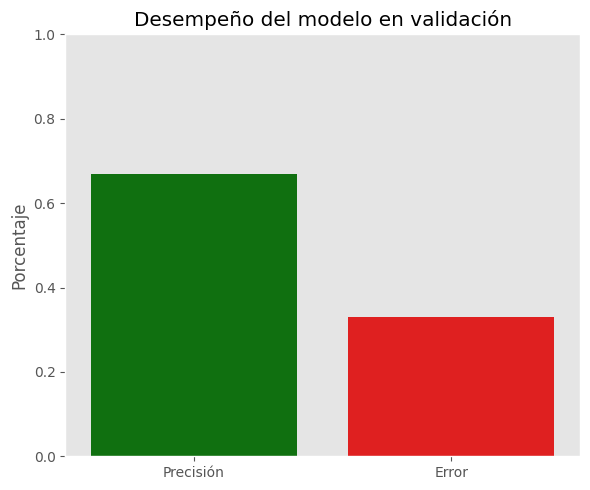

In [223]:
# Gráfico de barras: Precisión vs Error
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.barplot(x=["Precisión", "Error"], y=[precision, error], palette=["green", "red"])
plt.title("Desempeño del modelo en validación")
plt.ylim(0, 1)
plt.ylabel("Porcentaje")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [281]:
# === 9. Selección aleatoria de un obstáculo y predicción para temporada 11 ===

import random

# Seleccionar un obstáculo aleatorio
nombre_obstaculo = random.choice(df["Obstacle_Name"].unique())

# Filtrar el historial completo de ese obstáculo
historial = df[df["Obstacle_Name"] == nombre_obstaculo]

# Tomar su última aparición
ultima = historial.sort_values(by="Season", ascending=False).iloc[0]

# Construir entrada con las mismas características que el modelo
entrada = pd.DataFrame([{
    "Season": 11,  # simulamos la próxima temporada
    "Obstacle_Order": historial["Obstacle_Order"].mean(),  # estimado
    "apariciones_previas": historial["Season"].count(),
    "orden_promedio": historial["Obstacle_Order"].mean(),
    "etapas_diferentes": historial["Round/Stage"].nunique(),
    "ubicaciones_diferentes": historial["Location"].nunique()
}])

# Escalar la entrada
entrada_escalada = escalador.transform(entrada)

# Predecir probabilidad de retorno
probabilidad = modelo.predict_proba(entrada_escalada)[0][1]
pred_binaria = modelo.predict(entrada_escalada)[0]

# Mostrar resultado
print(f"🔍 Obstáculo seleccionado: {nombre_obstaculo}")
print(f"📅 Última temporada en la que apareció: {int(ultima['Season'])}")
print(f"🔮 Probabilidad de que aparezca en la temporada 11: {probabilidad:.2%}")
print(f"✅ Predicción: {'Sí aparecerá' if pred_binaria == 1 else 'No aparecerá'}")


🔍 Obstáculo seleccionado: Fallout
📅 Última temporada en la que apareció: 10
🔮 Probabilidad de que aparezca en la temporada 11: 34.50%
✅ Predicción: No aparecerá


REDES NEURONALES

In [283]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [284]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")


Dispositivo seleccionado: cuda


In [285]:
# Cargar dataset
df = pd.read_excel("American Ninja Warrior Obstacle History.xlsx")
df.columns = df.columns.str.strip().str.replace(" ", "_")
df = df.sort_values(by=["Obstacle_Name", "Season"])

# Crear columna con próxima temporada del obstáculo
df["siguiente_temp"] = df.groupby("Obstacle_Name")["Season"].shift(-1)

# Etiqueta: volvió en la siguiente temporada
df["vuelve_en_siguiente"] = (df["siguiente_temp"] == df["Season"] + 1).astype(int)

# Filtrar filas válidas
df_entrenamiento = df.dropna(subset=["siguiente_temp"]).copy()

# Crear características agregadas
df_entrenamiento["apariciones_previas"] = df_entrenamiento.groupby("Obstacle_Name")["Season"].transform("count")
df_entrenamiento["orden_promedio"] = df_entrenamiento.groupby("Obstacle_Name")["Obstacle_Order"].transform("mean")
df_entrenamiento["etapas_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Round/Stage"].transform("nunique")
df_entrenamiento["ubicaciones_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Location"].transform("nunique")


In [286]:
X = df_entrenamiento[[
    "Season", "Obstacle_Order", "apariciones_previas",
    "orden_promedio", "etapas_diferentes", "ubicaciones_diferentes"
]]
y = df_entrenamiento["vuelve_en_siguiente"]

# Dividir
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [287]:
class MLPBinario(nn.Module):
    def __init__(self, input_size):
        super(MLPBinario, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)


In [152]:
class MLP_Rondas(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_Rondas, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)  # sin softmax aquí, CrossEntropyLoss lo maneja
        return x


In [288]:
modelo = MLPBinario(input_size=X_train_tensor.shape[1]).to(device)
criterio = nn.BCELoss()
optimizador = optim.Adam(modelo.parameters(), lr=0.001, weight_decay=1e-4)


In [289]:
def entrenar_modelo(modelo, train_loader, test_loader, criterio, optimizador, epocas=30):
    historial = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    for epoca in range(epocas):
        modelo.train()
        loss_total, correctos, total = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizador.zero_grad()
            salida = modelo(X_batch).squeeze()
            loss = criterio(salida, y_batch)
            loss.backward()
            optimizador.step()
            
            loss_total += loss.item()
            pred = (salida > 0.5).float()
            correctos += (pred == y_batch).sum().item()
            total += y_batch.size(0)
        
        acc_train = 100 * correctos / total
        historial["train_loss"].append(loss_total / len(train_loader))
        historial["train_acc"].append(acc_train)

        # Validación
        modelo.eval()
        val_loss, val_correctos, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                salida = modelo(X_batch).squeeze()
                loss = criterio(salida, y_batch)
                val_loss += loss.item()
                pred = (salida > 0.5).float()
                val_correctos += (pred == y_batch).sum().item()
                val_total += y_batch.size(0)
        
        acc_val = 100 * val_correctos / val_total
        historial["val_loss"].append(val_loss / len(test_loader))
        historial["val_acc"].append(acc_val)

        print(f"Época {epoca+1}: Precisión entrenamiento {acc_train:.2f}%, validación {acc_val:.2f}%")
    
    return historial


Época 1: Precisión entrenamiento 73.45%, validación 72.93%
Época 2: Precisión entrenamiento 71.56%, validación 71.43%
Época 3: Precisión entrenamiento 72.13%, validación 73.68%
Época 4: Precisión entrenamiento 72.69%, validación 74.44%
Época 5: Precisión entrenamiento 74.20%, validación 73.68%
Época 6: Precisión entrenamiento 71.94%, validación 72.93%
Época 7: Precisión entrenamiento 72.32%, validación 73.68%
Época 8: Precisión entrenamiento 72.88%, validación 72.93%
Época 9: Precisión entrenamiento 72.50%, validación 73.68%
Época 10: Precisión entrenamiento 73.07%, validación 73.68%
Época 11: Precisión entrenamiento 73.63%, validación 73.68%
Época 12: Precisión entrenamiento 72.32%, validación 73.68%
Época 13: Precisión entrenamiento 74.01%, validación 72.93%
Época 14: Precisión entrenamiento 73.63%, validación 72.93%
Época 15: Precisión entrenamiento 73.63%, validación 74.44%
Época 16: Precisión entrenamiento 72.13%, validación 73.68%
Época 17: Precisión entrenamiento 72.50%, validac

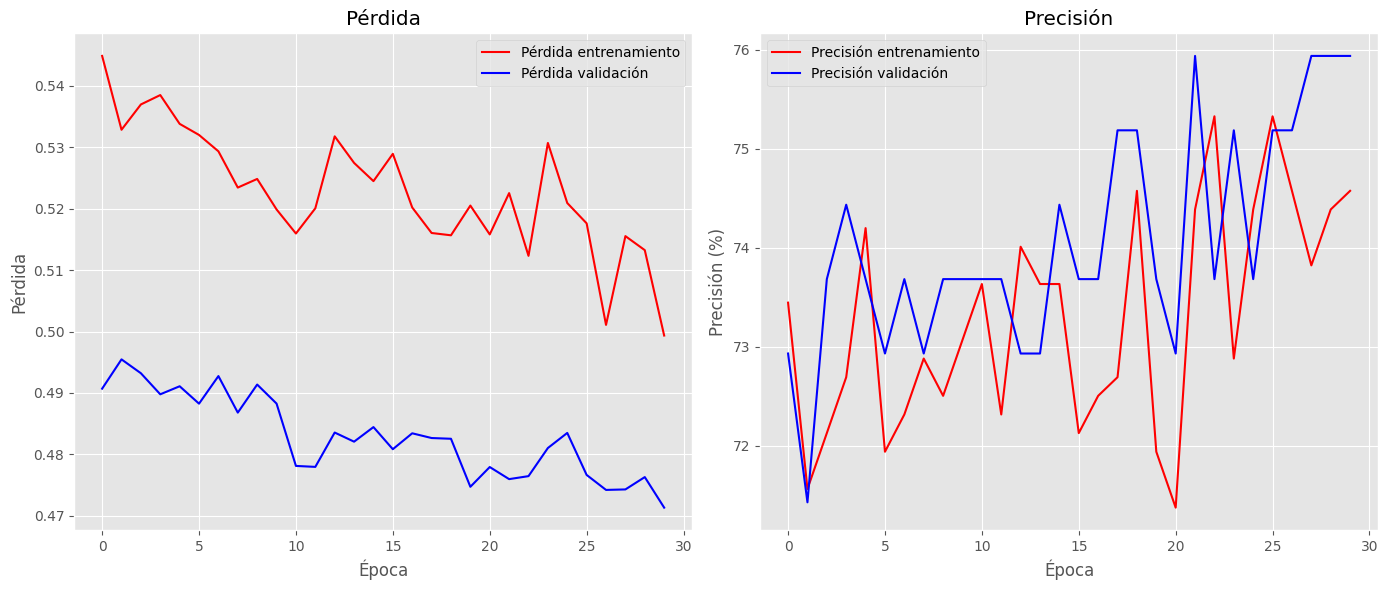

In [329]:
historial = entrenar_modelo(modelo, train_loader, test_loader, criterio, optimizador, epocas=30)

# Gráfica de pérdida y precisión lado a lado
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(historial["train_loss"], label="Pérdida entrenamiento", color="red")
plt.plot(historial["val_loss"], label="Pérdida validación", color="blue")
plt.title("Pérdida")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historial["train_acc"], label="Precisión entrenamiento", color="red")
plt.plot(historial["val_acc"], label="Precisión validación", color="blue")
plt.title("Precisión")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [328]:
# Selección aleatoria de obstáculo
import random
nombre = random.choice(df["Obstacle_Name"].unique())
historial = df[df["Obstacle_Name"] == nombre]
ultima = historial.sort_values(by="Season", ascending=False).iloc[0]

# Simular temporada 11
entrada = pd.DataFrame([{
    "Season": 11,
    "Obstacle_Order": historial["Obstacle_Order"].mean(),
    "apariciones_previas": historial["Season"].count(),
    "orden_promedio": historial["Obstacle_Order"].mean(),
    "etapas_diferentes": historial["Round/Stage"].nunique(),
    "ubicaciones_diferentes": historial["Location"].nunique()
}])

entrada_escalada = scaler.transform(entrada)
entrada_tensor = torch.FloatTensor(entrada_escalada).to(device)

modelo.eval()
with torch.no_grad():
    prob = modelo(entrada_tensor).item()
    pred_binaria = int(prob > 0.5)

print(f"🔍 Obstáculo: {nombre}")
print(f"📅 Última aparición: Temporada {int(ultima['Season'])}")
print(f"🔮 Probabilidad de aparecer en T11: {prob:.2%}")
print(f"✅ Predicción: {'Sí aparecerá' if pred_binaria else 'No aparecerá'}")


🔍 Obstáculo: Tarzan Rope
📅 Última aparición: Temporada 6
🔮 Probabilidad de aparecer en T11: 23.32%
✅ Predicción: No aparecerá


REPOSITORIO:

https://github.com/alexfernandez0804/1erParcial_SIS420